In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from shap import TreeExplainer, initjs, force_plot
from sklearn.linear_model import LinearRegression, Ridge
from numpy.random import permutation
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import plotly.graph_objects as go
import chart_studio

In [2]:
DATA_PATH = './data/'

In [9]:
###DATA WRANGLING/EDA

def wrangle(data):
    df = pd.read_csv(data,
                parse_dates=['last_scraped','host_since']
               ).set_index('last_scraped')
    
    #Dropping columns with high similarity columns
    df.drop(columns=['id','host_id','host_url','host_location',
                    'host_about','host_response_rate','host_listings_count',
                    'host_neighbourhood','host_total_listings_count',
                    'calendar_last_scraped','calculated_host_listings_count',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms',
                    'calculated_host_listings_count_shared_rooms',
                    'host_has_profile_pic','bathrooms','has_availability'], inplace=True)
    
    #Dropping columns about reviews and columns with low gini importance
    df.drop(columns=['review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication','review_scores_location',
                    'review_scores_value','reviews_per_month','minimum_nights','maximum_nights',
                    'availability_30','availability_60','availability_90',
                    'availability_365','number_of_reviews_ltm','number_of_reviews_l30d'], inplace=True)
    
    #Converted target as object into float
    df['price']  = df['price'].str.strip('$')
    df['price']  = df['price'].str.replace(',','').astype(float)
    
    #Dropped outliers
    df = df.loc[df['price'] < 50000]
    
    #Setting review scores rating as a categorical feature
    df['review_scores_rating'] = df['review_scores_rating'].fillna(0).round(-1).astype('int').astype('str')
    df['review_scores_rating'] = np.where(df['number_of_reviews']==0, 'no past ratings', df['review_scores_rating'])
    
    #Making use of the 'amenities' column
    items = ['Wireless Internet','Air conditioning', 'Kitchen', 'Heating','Family/kid friendly', 'Essentials', 'Hair dryer', 'Iron', 
                 'Smoke detector', 'Shampoo', 'Hangers', 'Hair dryer', 'Fire extinguisher', 'Laptop friendly workspace', 'First aid kit', 'Indoor fireplace',
                 'TV','Cable TV', 'Elevator in building']
    
    #Dropped High Cardinality and single value columns
    for item in items:
         df[item]=np.where(df['amenities'].str.contains(item), 1, 0)
    numcard = 10

    highcard = [col for col in df.select_dtypes(exclude='number')
            if df[col].nunique() > numcard]
    lowcard = [col for col in df
            if df[col].nunique() <= 1]           
    df.drop(columns=highcard, inplace=True)
    df.drop(columns=lowcard, inplace=True)
    
    
    #Converted t and f object type into 1 and 0
    df.replace('t',1, inplace=True)
    df.replace('f',0, inplace=True)
    
    #Preprocessed NaN values
    df['host_response_time'].fillna('within an hour',inplace=True)
    df['bedrooms'].fillna(1,inplace=True)
    
    #Dropping rows with NA values
    df = df.dropna(axis=0, subset=['bedrooms', 'beds'])
  
    
    return df

In [10]:
df = wrangle(DATA_PATH+'listings.csv')



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10889 entries, 2021-01-04 to 2021-01-01
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      10889 non-null  object 
 1   host_is_superhost       10873 non-null  float64
 2   host_identity_verified  10873 non-null  float64
 3   latitude                10889 non-null  float64
 4   longitude               10889 non-null  float64
 5   room_type               10889 non-null  object 
 6   accommodates            10889 non-null  int64  
 7   bedrooms                10889 non-null  float64
 8   beds                    10889 non-null  float64
 9   price                   10889 non-null  float64
 10  minimum_minimum_nights  10889 non-null  int64  
 11  maximum_minimum_nights  10889 non-null  int64  
 12  minimum_maximum_nights  10889 non-null  int64  
 13  maximum_maximum_nights  10889 non-null  int64  
 14  minimum_nights_avg_nt

In [12]:
###SPLITTING DATA
target = 'price'
y = df[target]
X = df.drop(columns=target)

In [13]:
cutoff = '2021-01-04'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [14]:
###ESTABLISHING BASELINE
print('Mean AirBnB Price:', y_train.mean())
y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))
print('Baseline RMSE:', mean_squared_error(y_train, y_pred, squared=False))

Mean AirBnB Price: 10374.170921579851
Baseline MAE: 6159.698199343448
Baseline RMSE: 8320.812532933393


In [15]:
###BUILDING MODELS

#Ridge Regressor

model_rr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge(alpha=10)
)

model_rr.fit(X_train, y_train);    

In [16]:
#RandomForestRegressor model

model_rf = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)

model_rf.fit(X_train, y_train); 

In [17]:

#XGboostRegressor model

model_xgb = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    XGBRegressor(random_state=42, 
                 n_jobs=-1,
                 verbose=True)
);


model_xgb.fit(X_train, y_train);



[14:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [18]:
###CHECKING METRICS

#Ridge model metrics
y_pred_train_rr = model_rr.predict(X_train)
y_pred_test_rr = model_rr.predict(X_test)
train_MAE_rr = mean_absolute_error(y_train, y_pred_train_rr)
test_MAE_rr = mean_absolute_error(y_test, y_pred_test_rr)
train_RMSE_rr = mean_squared_error(y_train, y_pred_train_rr, squared=False)
test_RMSE_rr = mean_squared_error(y_test, y_pred_test_rr, squared=False)

print('RIDGE REGRESSOR METRICS:')
print('Train MAE:',train_MAE_rr)
print('Test MAE:', test_MAE_rr)
print('Train RMSE:', train_RMSE_rr)
print('Test RMSE:', test_RMSE_rr)
print('Training R^2:', r2_score(y_train, model_rr.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rr.predict(X_test)))
print('Training Accuracy:', model_rr.score(X_train, y_train))
print('Test Accuracy:', model_rr.score(X_test, y_test))

#RF Regressor metrics
y_pred_train_rf = model_rf.predict(X_train)
y_pred_test_rf = model_rf.predict(X_test)
train_MAE_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_MAE_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_RMSE_rf = mean_squared_error(y_train, y_pred_train_rf, squared=False)
test_RMSE_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)
print('')
print('RF REGRESSOR METRICS:')
print('Train MAE:',train_MAE_rf)
print('Test MAE:', test_MAE_rf)
print('Train RMSE:', train_RMSE_rf)
print('Test RMSE:', test_RMSE_rf)
print('Training R^2:', r2_score(y_train, model_rf.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rf.predict(X_test)))
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Test Accuracy:', model_rf.score(X_test, y_test))

#XGB model metrics
y_pred_train_xgb = model_xgb.predict(X_train)
y_pred_test_xgb = model_xgb.predict(X_test)
train_MAE_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_RMSE_xgb = mean_squared_error(y_train, y_pred_train_xgb, squared=False)
test_RMSE_xgb = mean_squared_error(y_test, y_pred_test_xgb, squared=False)
print('')
print('XGBOOST METRICS:')
print('Train MAE:',train_MAE_xgb)
print('Test MAE:', test_MAE_xgb)
print('Train RMSE:', train_RMSE_xgb)
print('Test RMSE:', test_RMSE_xgb)
print('Training R^2:', r2_score(y_train, model_xgb.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_xgb.predict(X_test)))
print('Training Accuracy:', model_xgb.score(X_train, y_train))
print('Test Accuracy:', model_xgb.score(X_test, y_test))


RIDGE REGRESSOR METRICS:
Train MAE: 4838.320468916904
Test MAE: 4759.909101294049
Train RMSE: 6810.623710343867
Test RMSE: 6537.214816523465
Training R^2: 0.330050145727098
Test R^2: 0.26367861176541907
Training Accuracy: 0.330050145727098
Test Accuracy: 0.26367861176541907

RF REGRESSOR METRICS:
Train MAE: 1326.659025393191
Test MAE: 3683.040767280512
Train RMSE: 2146.754431318059
Test RMSE: 5636.444955717567
Training R^2: 0.9334369427320268
Test R^2: 0.45261556581419415
Training Accuracy: 0.9334369427320268
Test Accuracy: 0.45261556581419415

XGBOOST METRICS:
Train MAE: 2240.8078705026137
Test MAE: 3906.9567478360573
Train RMSE: 3338.336107606192
Test RMSE: 5800.998319967042
Training R^2: 0.8390360412215631
Test R^2: 0.42018775564497457
Training Accuracy: 0.8390360412215631
Test Accuracy: 0.42018775564497457


In [282]:
###TUNING (HYPERPARAM TUNING AND COMPARING GINI IMPORTANCE AND PERMUTATION IMPORTANCE)

#Hyperparam tuning for ridge model
rr_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'ridge__alpha': [1,5,10,15,20,25],
}

model_rr_gs = GridSearchCV(
    model_rr,
    param_grid=rr_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rr_gs.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [292]:


rf_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators': [100,150,200,250,300],
    'randomforestregressor__max_depth': range(5, 36, 3)
}

model_rf_gs = GridSearchCV(
    model_rf,
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rf_gs.fit(X_train, y_train);


Fitting 5 folds for each of 110 candidates, totalling 550 fits


In [284]:
xgb_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__max_depth': range(3,15,3),
    'xgbregressor__gamma': range(1,5,1),
    'xgbregressor__n_estimators': range(5,30,5)
}

model_xgb_gs = GridSearchCV(
    model_xgb,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_xgb_gs.fit(X_train, y_train);


Fitting 5 folds for each of 160 candidates, totalling 800 fits
[04:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [294]:
#Ridge modelv2 metrics
y_pred_train_rr_gs = model_rr_gs.predict(X_train)
y_pred_test_rr_gs = model_rr_gs.predict(X_test)
train_MAE_rr_gs = mean_absolute_error(y_train, y_pred_train_rr_gs)
test_MAE_rr_gs = mean_absolute_error(y_test, y_pred_test_rr_gs)
train_RMSE_rr_gs = mean_squared_error(y_train, y_pred_train_rr_gs, squared=False)
test_RMSE_rr_gs = mean_squared_error(y_test, y_pred_test_rr_gs, squared=False)
print('RIDGE REGRESSORv2 METRICS:')
print('Train MAE:',train_MAE_rr_gs)
print('Test MAE:', test_MAE_rr_gs)
print('Train RMSE:', train_RMSE_rr_gs)
print('Test RMSE:', test_RMSE_rr_gs)
print('Training R^2:', r2_score(y_train, model_rr_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rr_gs.predict(X_test)))
#RF modelv2 metrics
y_pred_train_rf_gs = model_rf_gs.predict(X_train)
y_pred_test_rf_gs = model_rf_gs.predict(X_test)
train_MAE_rf_gs = mean_absolute_error(y_train, y_pred_train_rf_gs)
test_MAE_rf_gs = mean_absolute_error(y_test, y_pred_test_rf_gs)
train_RMSE_rf_gs = mean_squared_error(y_train, y_pred_train_rf_gs, squared=False)
test_RMSE_rf_gs = mean_squared_error(y_test, y_pred_test_rf_gs, squared=False)
print('')
print('RF REGRESSORv2 METRICS:')
print('Train MAE:',train_MAE_rf_gs)
print('Test MAE:', test_MAE_rf_gs)
print('Train RMSE:', train_RMSE_rf_gs)
print('Test RMSE:', test_RMSE_rf_gs)
print('Training R^2:', r2_score(y_train, model_rf_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_rf_gs.predict(X_test)))

#XGB modelv2 metrics
y_pred_train_xgb_gs = model_xgb_gs.predict(X_train)
y_pred_test_xgb_gs = model_xgb_gs.predict(X_test)
train_MAE_xgb_gs = mean_absolute_error(y_train, y_pred_train_xgb_gs)
test_MAE_xgb_gs = mean_absolute_error(y_test, y_pred_test_xgb_gs)
train_RMSE_xgb_gs = mean_squared_error(y_train, y_pred_train_xgb_gs, squared=False)
test_RMSE_xgb_gs = mean_squared_error(y_test, y_pred_test_xgb_gs, squared=False)
print('')
print('XGBoost Regressorv2 METRICS:')
print('Train MAE:',train_MAE_xgb_gs)
print('Test MAE:', test_MAE_xgb_gs)
print('Train RMSE:', train_RMSE_xgb_gs)
print('Test RMSE:', test_RMSE_xgb_gs)
print('Training R^2:', r2_score(y_train, model_xgb_gs.predict(X_train)))
print('Test R^2:', r2_score(y_test, model_xgb_gs.predict(X_test)))
print('Model best score:', model_xgb_gs.best_score_)

RIDGE REGRESSORv2 METRICS:
Train MAE: 4788.255452525767
Test MAE: 4685.763729324461
Train RMSE: 6766.797399879798
Test RMSE: 6470.756228768829
Training R^2: 0.33864464786549675
Test R^2: 0.27857368260091253

RF REGRESSORv2 METRICS:
Train MAE: 1310.9116336563968
Test MAE: 3674.9020842206946
Train RMSE: 2103.0226132787975
Test RMSE: 5608.311464369353
Training R^2: 0.9361212498543775
Test R^2: 0.4580663073189448

XGBoost Regressorv2 METRICS:
Train MAE: 4238.691045248188
Test MAE: 4346.137845236833
Train RMSE: 6133.167712439092
Test RMSE: 6129.750891983886
Training R^2: 0.4567018748002347
Test R^2: 0.3526076635752301
Model best score: 0.35815941347830654


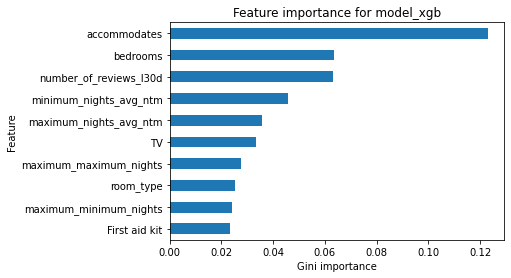

In [81]:
#Gini importance
importances = model_xgb.named_steps['xgbregressor'].feature_importances_

feat_imp = pd.Series(importances, index=X.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_xgb');

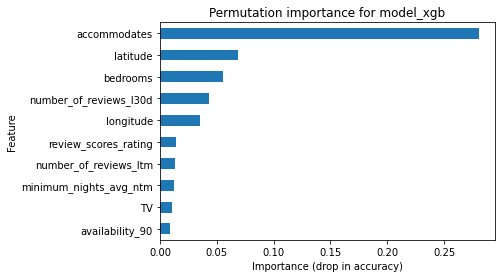

In [83]:
#Permutation importance
perm_imp = permutation_importance(model_xgb_gs,
                                   X_test,
                                   y_test,
                                   n_jobs=-1,
                                   random_state=42)

data_ = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}


permdf = pd.DataFrame(data_, index=X_test.columns)
permdf.sort_values(by='importances_mean', inplace=True)

permdf['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

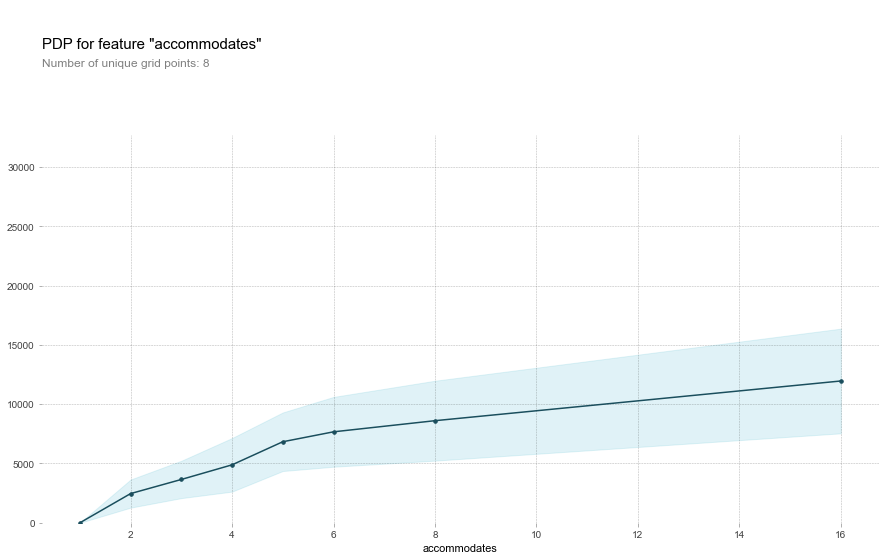

In [84]:
###COMMUNICATING RESULTS

feature = 'accommodates'

#Plotting partial dependency for 'accommodates' feature
isolate = pdp_isolate(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

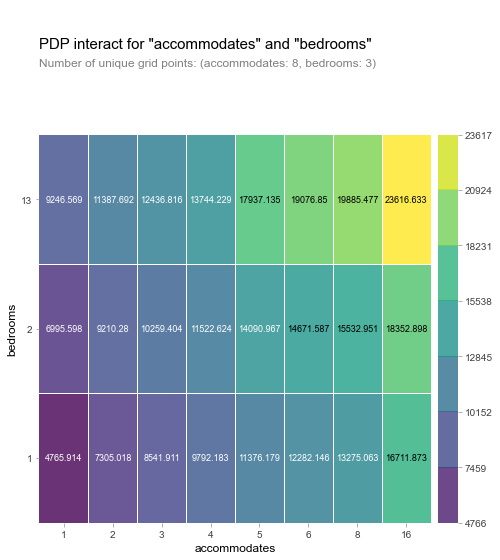

In [85]:
#Plotting partial dependency for the first top 2 features:
#('bedroom' and 'accomodates')

top2feat = ['accommodates', 'bedrooms']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=top2feat
)

pdp_interact_plot(interact, plot_type='grid',feature_names=top2feat);

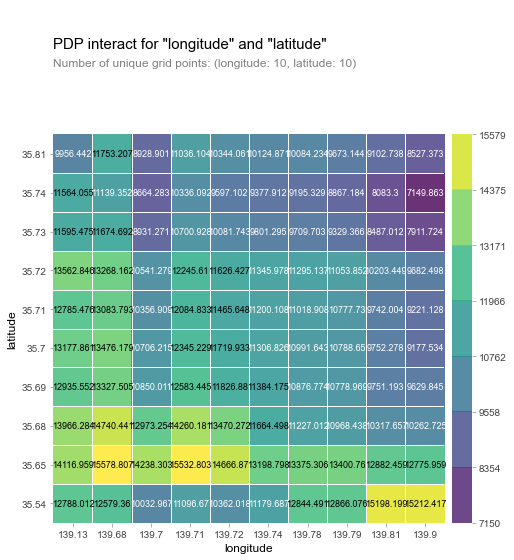

In [86]:
location = ['longitude', 'latitude']


interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features = location
)

pdp_interact_plot(interact, plot_type='grid',feature_names=location);

In [22]:
df.corr()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_minimum_nights,maximum_minimum_nights,...,Essentials,Hair dryer,Iron,Shampoo,Hangers,Fire extinguisher,First aid kit,Indoor fireplace,TV,Cable TV
host_is_superhost,1.000000,0.121898,-0.053061,-0.045731,0.006598,0.049757,0.019496,0.032001,-0.032472,-0.008949,...,0.042100,0.040948,0.103626,0.040843,0.134071,0.007420,0.078067,-0.020096,0.051983,0.033969
host_identity_verified,0.121898,1.000000,0.002053,0.008112,0.089250,0.057000,0.048406,-0.001057,0.041011,0.060162,...,0.057459,0.018286,0.030425,0.040534,0.107410,0.005072,0.033376,0.019905,-0.016095,0.000046
latitude,-0.053061,0.002053,1.000000,0.191362,0.041321,0.057676,0.020971,-0.051023,0.061421,0.068566,...,-0.066998,0.011812,-0.138427,-0.064465,-0.016788,0.026570,-0.050734,0.031715,-0.079667,0.016204
longitude,-0.045731,0.008112,0.191362,1.000000,0.055750,0.043494,0.036448,-0.000739,-0.019389,-0.026946,...,-0.041478,0.021553,-0.014924,0.017643,-0.053402,0.067814,-0.021309,-0.042910,-0.030061,-0.014927
accommodates,0.006598,0.089250,0.041321,0.055750,1.000000,0.623311,0.681575,0.523786,-0.046328,-0.048575,...,0.114018,0.040626,0.143419,0.091825,0.084039,-0.010661,0.037566,0.032646,0.161818,0.066113
bedrooms,0.049757,0.057000,0.057676,0.043494,0.623311,1.000000,0.597439,0.382345,-0.023940,-0.031593,...,0.031851,-0.023062,0.082441,0.018050,0.023263,-0.003033,0.042113,0.038138,0.085976,0.051146
beds,0.019496,0.048406,0.020971,0.036448,0.681575,0.597439,1.000000,0.388454,-0.046454,-0.058331,...,0.061894,0.011587,0.097628,0.055439,0.021867,-0.006618,0.061570,0.010201,0.088672,0.035369
price,0.032001,-0.001057,-0.051023,-0.000739,0.523786,0.382345,0.388454,1.000000,-0.067929,-0.085910,...,0.083644,0.036828,0.082432,0.071978,0.061345,-0.033723,-0.015484,0.025111,0.159750,0.084474
minimum_minimum_nights,-0.032472,0.041011,0.061421,-0.019389,-0.046328,-0.023940,-0.046454,-0.067929,1.000000,0.911035,...,-0.054542,0.008229,-0.055289,-0.062470,0.015880,0.020857,0.073495,-0.011546,-0.069762,-0.009831
maximum_minimum_nights,-0.008949,0.060162,0.068566,-0.026946,-0.048575,-0.031593,-0.058331,-0.085910,0.911035,1.000000,...,-0.038356,0.015635,-0.014891,-0.046340,0.035044,0.040603,0.034057,-0.017912,-0.036354,-0.020904
